<a href="https://colab.research.google.com/github/j6k4m8/CIS522-DL-Tribiotics/blob/main/ML_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CIS 522 Final Project - DL Interpretability in COVID X-ray


**Team**: Tribiotics\
**Team Members**: Trevor Chan, Jordan Matelsky, Jiazhen Rong

### Setup

In [1]:
import torch
import torch.nn as nn
from torch.utils import data
from torchvision.models import vgg19
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torch.utils.data import DataLoader
import random
import IPython
import torchvision
import cv2
from PIL import Image

In [2]:
!pip install opendatasets

In [3]:
import opendatasets as od

In [4]:
## download the Kaggle dataset of COVID lung X-ray 
# get your API from Kaggle, see https://www.analyticsvidhya.com/blog/2021/04/how-to-download-kaggle-datasets-using-jupyter-notebook/
od.download("https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database/download")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: jordanmatelsky
Your Kaggle Key: ··········


100%|██████████| 778M/778M [00:03<00:00, 213MB/s]


In [5]:
# create an annotation file of file name + labels within the image directory
img_dir="/content/covid19-radiography-database/COVID-19_Radiography_Dataset/"
covid_images = os.listdir(img_dir+'COVID/images')
covid_images = [img_dir + 'COVID/images/' + img for img in covid_images]
normal_images = os.listdir(img_dir+'Normal/images')
normal_images = [img_dir + 'Normal/images/' + img for img in normal_images]
pneumonia_images= os.listdir(img_dir+'Viral Pneumonia/images')
pneumonia_images = [img_dir + 'Viral Pneumonia/images/' +img for img in pneumonia_images]
# masking folder
covid_mask = os.listdir(img_dir+'COVID/masks')
covid_mask = [img_dir + 'COVID/masks/' + img for img in covid_mask]
normal_mask = os.listdir(img_dir+'Normal/masks')
normal_mask = [img_dir + 'Normal/masks/' + img for img in normal_mask]
pneumonia_mask = os.listdir(img_dir+'Viral Pneumonia/masks')
pneumonia_mask = [img_dir + 'Viral Pneumonia/masks/' +img for img in pneumonia_mask]

# create label
meta_df = pd.DataFrame(data={'data_path':covid_images+normal_images + pneumonia_images,
                             'label':[0]*len(covid_images) + [1]*len(normal_images) + [2]*len(pneumonia_images),
                              'masking': covid_mask+normal_mask + pneumonia_mask})
meta_df.to_csv(img_dir+"all_file_label.txt",sep='\t')

# split into 80% train, 10% validation and 10% test files
random.seed(522)
train_idx = np.random.choice(list(range(meta_df.shape[0])),size=int(meta_df.shape[0]*0.8),replace=False)
val_idx = np.random.choice(list(set(list(range(meta_df.shape[0]))) - set((train_idx))),size=int(meta_df.shape[0]*0.1),replace=False)
test_idx = np.array(list(set(list(range(meta_df.shape[0]))) - set(val_idx) - set(train_idx)))
meta_df.iloc[train_idx,:].to_csv(img_dir+"train_split.txt",sep='\t')
meta_df.iloc[val_idx,:].to_csv(img_dir+"val_split.txt",sep='\t')
meta_df.iloc[test_idx,:].to_csv(img_dir+"test_split.txt",sep='\t')

### Data Pre-processing

In [6]:
# customized data loader to save memory
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, transform=None, train_transform=None,target_transform=None,mask_transform=None,train=True,masking=False, antimasking=False):
        self.annotations_file = pd.read_csv(annotations_file,sep='\t',index_col=0)
        #self.img_dir = img_dir
        self.transform = transform
        self.train_transform = train_transform
        self.train=train
        self.target_tranform= target_transform
        self.masking = masking 
        self.antimasking = antimasking
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.annotations_file)

    def __getitem__(self, idx):
        img_path = self.annotations_file.iloc[idx, 0] # image
        mask_path = self.annotations_file.iloc[idx, 2] # masking
        image = read_image(img_path)
        mask = read_image(mask_path)/255

        ## Change 1x299x299 images to 3x299x299 to keep consistency between datasets.
        if image.shape[0] == 1:
          image = torch.tile(image,(3,1,1))

        # apply masking on image before any other transformation
        if self.masking == True: 
          image = self.mask_transform(image) # resize image to be same size as mask, mask size: 3*256*256
          image = image * mask
        elif self.antimasking == True: 
          image = self.mask_transform(image) # resize image to be same size as mask, mask size: 3*256*256
          image = image * -1 * (1-mask)

        label = self.annotations_file.iloc[idx, 1] # image label, 0 for covid, 1 for normal, 2 for pneumonia

        if self.train: # for training case, additional transformation
            image = self.train_transform(image)
        else:  # for validation and test case
            image = self.transform(image)
        if self.target_tranform != None:
            label = self.target_transform(label)

        return image, label

##### Without masking

In [7]:
annotation_file=img_dir+"all_file_label.txt"
train_file = img_dir+"train_split.txt"
val_file = img_dir+"val_split.txt"
test_file = img_dir+"test_split.txt"

# Define image transformations
# transformations - can add more transformation here, like resize for different models, etc.
all_transforms = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.Resize((224, 224)), 
                    transforms.ToTensor(), 
                    # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet images common scale factors
                    #transforms.Normalize((0.5), (0.5)), # the covid is only 1D
                    ])

# Make image size size as masking
mask_transform = transforms.Compose([
                    transforms.Resize((256, 256)), 
                    ])
# can add augmentations here for training images
train_transforms = transforms.Compose([
                    transforms.ToPILImage(),
                    # transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation(degrees=5), 
                    transforms.Resize((224, 224)), 
                    transforms.ToTensor(), 
                    # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                    #transforms.Normalize((0.5), (0.5)), # the covid is only 1D
                    ])

full_training_data = CustomImageDataset(
    annotations_file= train_file,
    transform=all_transforms,
    train_transform = train_transforms,
    train=True,
    masking=False,
    antimasking=False,
    mask_transform=mask_transform
)
full_val_data = CustomImageDataset(
    annotations_file= val_file,
    transform=all_transforms,
    train=False,
    masking=False,
    antimasking=False,
    mask_transform=mask_transform
)
full_test_data = CustomImageDataset(
    annotations_file= test_file,
    transform=all_transforms,
    train=False,
    masking=False,
    antimasking=False,
    mask_transform=mask_transform
)


mask_training_data = CustomImageDataset(
    annotations_file= train_file,
    transform=all_transforms,
    train_transform = train_transforms,
    train=True,
    masking=True,
    antimasking=False,
    mask_transform=mask_transform
)
mask_val_data = CustomImageDataset(
    annotations_file= val_file,
    transform=all_transforms,
    train=False,
    masking=True,
    antimasking=False,
    mask_transform=mask_transform
)
mask_test_data = CustomImageDataset(
    annotations_file= test_file,
    transform=all_transforms,
    train=False,
    masking=True,
    antimasking=False,
    mask_transform=mask_transform
)


anti_training_data = CustomImageDataset(
    annotations_file= train_file,
    transform=all_transforms,
    train_transform = train_transforms,
    train=True,
    masking=False,
    antimasking=True,
    mask_transform=mask_transform
)
anti_val_data = CustomImageDataset(
    annotations_file= val_file,
    transform=all_transforms,
    train=False,
    masking=False,
    antimasking=True,
    mask_transform=mask_transform
)
anti_test_data = CustomImageDataset(
    annotations_file= test_file,
    transform=all_transforms,
    train=False,
    masking=False,
    antimasking=True,
    mask_transform=mask_transform
)

In [8]:
full_train_dataloader = DataLoader(full_training_data, batch_size=64, shuffle=True)
full_val_dataloader = DataLoader(full_val_data, batch_size=64, shuffle=True)
full_test_dataloader = DataLoader(full_test_data, batch_size=64, shuffle=True)

mask_train_dataloader = DataLoader(mask_training_data, batch_size=64, shuffle=True)
mask_val_dataloader = DataLoader(mask_val_data, batch_size=64, shuffle=True)
mask_test_dataloader = DataLoader(mask_test_data, batch_size=64, shuffle=True)

anti_train_dataloader = DataLoader(anti_training_data, batch_size=64, shuffle=True)
anti_val_dataloader = DataLoader(anti_val_data, batch_size=64, shuffle=True)
anti_test_dataloader = DataLoader(anti_test_data, batch_size=64, shuffle=True)

# Logistic Regression Model

In [12]:
# ser common parameters
num_classes = 3 # 0,1,2 for covid, normal and pneumonia
DEVICE="cuda"
lr = 0.001

In [28]:
class LogisticRegression(torch.nn.Module):

    def __init__(self, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.LazyLinear(output_dim)

    def forward(self, x):
        outputs = torch.sigmoid(self.linear(x))
        return outputs

In [29]:
model = LogisticRegression(num_classes).to(DEVICE)

crit = torch.nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(), lr=lr)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [36]:
iter = 0
for epoch in range(2):
    for i, (images, labels) in enumerate(full_train_dataloader):
        images = images.view(-1, 3 * 224 * 224).to(DEVICE)
        labels = labels.to(DEVICE)

        opt.zero_grad()
        outputs = model(images)
        loss = crit(outputs, target=labels)
        loss.backward()
        opt.step()

        iter+=1

        if iter%50==0:
            # calculate Accuracy
            correct = 0
            total = 0
            for images, labels in full_test_dataloader:
                images = images.view(-1, 3 * 224 * 224).to(DEVICE)
                labels = labels.to(DEVICE)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total+= labels.size(0)
                # for gpu, bring the predicted and labels back to cpu fro python operations to work
                correct+= (predicted == labels).sum()
            accuracy = 100 * correct/total
            print("Iteration: {}. Loss: {}. Accuracy: {}.".format(iter, loss.item(), accuracy))

Iteration: 5. Loss: 0.8648755550384521. Accuracy: 65.43535614013672.
Iteration: 10. Loss: 0.8291496634483337. Accuracy: 65.43535614013672.
Iteration: 15. Loss: 0.9157567620277405. Accuracy: 65.36939239501953.
Iteration: 20. Loss: 0.8549507260322571. Accuracy: 65.43535614013672.
Iteration: 25. Loss: 0.8832454681396484. Accuracy: 65.43535614013672.
Iteration: 30. Loss: 0.8893009424209595. Accuracy: 65.43535614013672.
Iteration: 35. Loss: 0.8857873678207397. Accuracy: 65.43535614013672.
Iteration: 40. Loss: 0.8735547661781311. Accuracy: 65.43535614013672.


KeyboardInterrupt: ignored

In [38]:
# Visualize Confusion Matrix
# Code adapated from https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
with torch.no_grad():
  for images,labels in full_test_dataloader:
        images = images.view(-1, 3 * 224 * 224).to(DEVICE)
        labels = labels.to(DEVICE)
        output = model(images) # Feed Network
        predictions = torch.argmax(output, dim=1).data.cpu().numpy()
        y_pred.extend(predictions) # Save Prediction
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('COVID', 'Normal', 'Pneumonia')

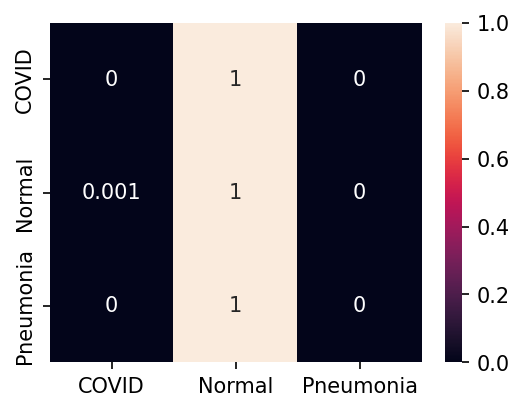

In [40]:
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred,normalize='true')
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (4,3), dpi=150)
sn.heatmap(df_cm, annot=True)
plt.savefig('confusion_matrix_anti.png', dpi = 300)

In [102]:
# Render pixelwise importance from the logistic regression

# get the weights of the logistic regression
weights = model.linear.weight.data.cpu().numpy()

# get the pixelwise importance
importance = np.abs(weights).sum(axis=0)
importance = np.log(1+np.sum(weights, axis=0))


Text(0.5, 1.0, 'Pixelwise Feature Importance')

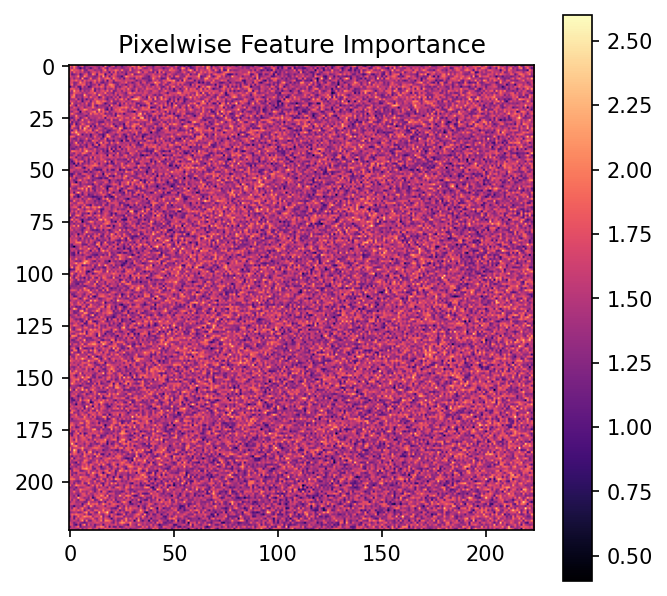

In [105]:
plt.figure(figsize=(5, 5), dpi=150)
imp = importance - importance.min()
imp /= imp.max()
ren = imp.reshape(3, 224, 224).sum(axis=0)
plt.imshow(ren, cmap='magma')
plt.colorbar()
plt.title("Pixelwise Feature Importance")

In [59]:
weights.shape

(3, 150528)

In [69]:
model

LogisticRegression(
  (linear): Linear(in_features=150528, out_features=3, bias=True)
)

[1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 2 1 1 1 1 1
 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 0 1 1 2 1 1 1 1 2]
[1 1 1 1 0 2 1 1 1 0 1 1 1 1 0 1 1 2 0 1 1 1 1 2 0 1 1 1 1 1 2 0 1 0 1 1 0
 1 1 2 1 1 1 1 1 2 1 0 1 1 1 0 1 1 0 0 1 1 1 0 0 0 1 1]
0.640625
[0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 2 1 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1]
[0 1 1 0 0 1 1 0 0 1 1 1 1 1 0 0 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 2 1 0
 1 0 1 0 0 1 1 1 1 1 1 1 0 0 2 1 1 1 1 2 1 1 1 1 1 1 0]
0.75
[2 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 2 1 1 2 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 2]
[2 1 1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 0 2 0 1 0 0 0 0 1 1 0 1 0 1 0 2 1
 1 2 1 1 1 0 1 2 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 2]
0.71875
[1 1 1 1 1 2 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 1 1 1 1 1 0 1 2 1 2 1 1
 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1]
[1 1 1 1 0 2 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 2 1 2 1 1 

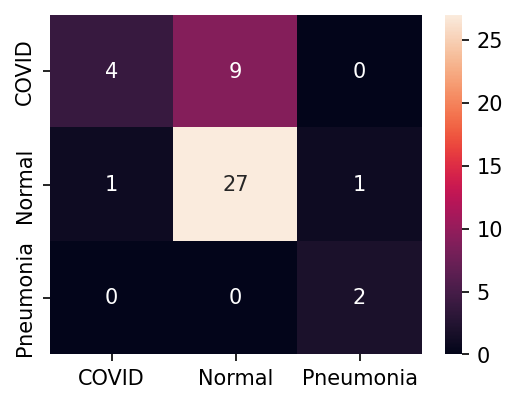

In [76]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
for images, labels in full_train_dataloader:
    images = images.view(-1, 3 * 224 * 224).to(DEVICE)
    labels = labels.to(DEVICE)
    # partial fit
    rf.fit(images.data.cpu().numpy(), labels.data.cpu().numpy())
    break

# predict
for images, labels in full_test_dataloader:
    images = images.view(-1, 3 * 224 * 224).to(DEVICE)
    labels = labels.to(DEVICE)
    outputs = rf.predict(images.data.cpu().numpy())
    # print(outputs)
    # print(labels.data.cpu().numpy())
    # print(accuracy_score(labels.data.cpu().numpy(), outputs))

# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

confusion_matrix = confusion_matrix(labels.data.cpu().numpy(), outputs)
df_cm = pd.DataFrame(confusion_matrix, index = [i for i in classes],
                        columns = [i for i in classes])
plt.figure(figsize = (4,3), dpi=150)
sn.heatmap(df_cm, annot=True)


Text(0.5, 1.0, 'Pixelwise Feature Importance')

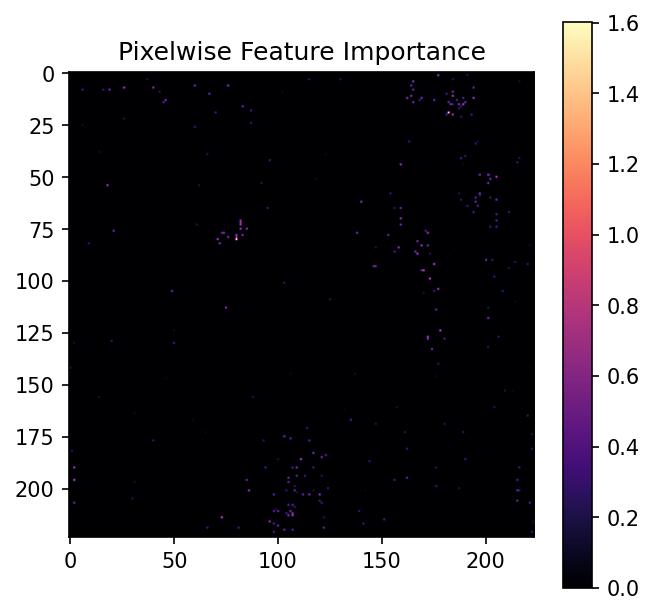

In [79]:
imp = rf.feature_importances_ - rf.feature_importances_.min() 
imp /= rf.feature_importances_.max()

plt.figure(figsize=(5, 5), dpi=150)
plt.imshow(imp.reshape(3, 224, 224).sum(axis=0), cmap='magma')
plt.colorbar()
plt.title("Pixelwise Feature Importance")